# Quantifying watermass transformations by surface  by density class into the VIKING20X model.

## Transformations by surface heat and freshwater fluxes

### Technical preample

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as c
import matplotlib.dates as mdates
import seawater as sw
from xhistogram.xarray import histogram

import seaborn as sns
import cmocean as co     # for details on this colormap module see https://matplotlib.org/cmocean/

### Global plot options

In [2]:
sns.set(style="whitegrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

plt.rcParams['figure.figsize'] = [9, 7]
plt.rcParams.update({'font.size': 17})
years_fmt = mdates.DateFormatter('%Y-%m-%d')
sns.set_palette("colorblind")

### Dask stuff
Runs without this on  reduced area array, so let xarray defaults deal with it

In [3]:
from dask.distributed import Client

In [4]:
client = Client(n_workers=8, threads_per_worker=2, memory_limit=30e9, ip="0.0.0.0")
client

Client Scheduler: tcp://10.0.4.71:40217 Dashboard: http://10.0.4.71:37865/status,Cluster Workers: 8 Cores: 16 Memory: 240.00 GB


_(Click on the link above if you want to see the Dask cluster in action.)_

## Parameters

In [5]:
# paramters

# Project path
path_project = Path.cwd() / '..' / '..' 
path_project = path_project.resolve()

# path to osnap section definition
path_section = path_project / 'data' / 'external'
filename_section = 'osnap_pos_wp.txt'
sectionname = 'osnap'

# Section data file
path_data_output = path_project / 'data' / 'interim' / 'watermassBudget' / 'surfaceFluxes' 

# path to viking20 data
global_data_path = Path("/gxfs_work1/geomar/smomw355/model_data/ocean-only/")
experiment_id = "VIKING20X.L46-KKG36107B"
nest_prefix = "1"

mean_period = "1m"
year = 1990

In [6]:
yearstr = str(year)

## Load VIKING20X data

We'll first find all the relevant files and then open them as a virtual contiguous dataset.

In [7]:
T_files = (global_data_path / experiment_id / "nemo/output/").glob(f"{nest_prefix}_{experiment_id}_{mean_period}_{yearstr}????_{yearstr}????_grid_T.nc")
T_files = list(sorted(T_files))
print(f"found {len(T_files)} grid-T files")

# mask_files = (path_global_data / "mask" / experiment_id).glob(f"{nest_prefix}_mask*.nc")
# mask_files = list(sorted(mask_files))
# print(f"found {len(mask_files)} mask files")

mesh_mask_files = (global_data_path / experiment_id / "nemo/suppl/").glob(f"{nest_prefix}_mesh_mask*.nc")
mesh_mask_files = list(sorted(mesh_mask_files))
print(f"found {len(mesh_mask_files)} mesh mask files")

mask_files = mesh_mask_files
print(f"found {len(mask_files)} mesh mask files")


found 1 grid-T files
found 1 mesh mask files
found 1 mesh mask files


In [8]:
gridT = xr.open_mfdataset(
    T_files,
#     chunks={
#         "time_counter": 1, "deptht": 1,
#         "y": 256, "x": 1024
#     },
    combine='by_coords'
)
mask = xr.open_dataset(mask_files[0],
#     chunks={
#         "t": 1, "z": 1,
#         "y": 256, "x": 1024
#     },
)
mesh_mask = xr.open_dataset(mesh_mask_files[0],
#     chunks={
#         "z": 1,
#         "y": 256, "x": 1024
#     },
)

## Define a section and find grid points along the section

Reads in the OSNAP section data

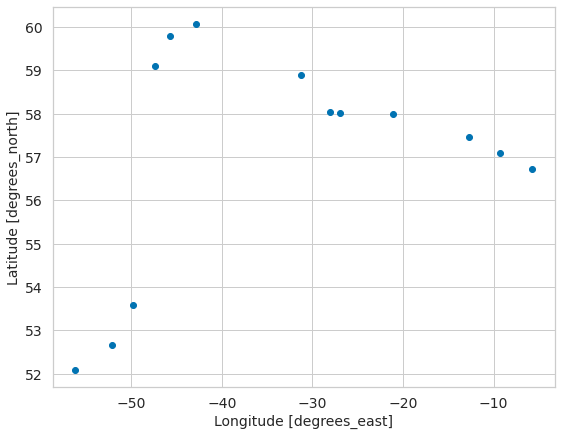

In [9]:
lonlat = xr.Dataset(pd.read_csv(path_section / filename_section,delim_whitespace=True))

lonlat

lonlat.lon.attrs['long_name']='Longitude'
lonlat.lat.attrs['long_name']='Latitude'
lonlat.lon.attrs['standard_name']='longitude'
lonlat.lat.attrs['standard_name']='latitude'
lonlat.lon.attrs['units']='degrees_east'
lonlat.lat.attrs['units']='degrees_north'

lonlat.plot.scatter(x='lon',y='lat')

ll_points = np.vstack((lonlat.lat.data, lonlat.lon.data)).T
ll_points = ll_points[0:6]

## Find related indices

This takes an inordinate amount of time, because `get_ij` will transform grid points on the (spherical) earth to 3D, and do the nearest-neighbor-lookup there. There are faster ways. Probably more efficient for many points.

In [10]:
# # no need to run this every time, just save the coordinates for later. (WARNING: not working on reduce array)

# vertices_ji = get_ij(
#     mesh_mask,
#     ll_points,
#     grid="f",
#     xgcm=False,
#     xarray_out=False
# )

#### The saved VIKING20X grid coordinates

In [11]:
vertices_ji = np.array([[1959,870],
 [1969,  950],
 [1995, 998],
 [2172, 1067],
 [2192, 1099],
 [2194, 1152],
 [2139, 1352],
 [2111, 1410],
 [2109, 1429],
 [2110, 1533],
 [2103, 1685],
 [2097, 1747],
 [2093, 1812]])


### Cut out small area
To speed calculations

In [12]:
xmin=600
xmax=1200
ymin=1900
ymax=None

In [13]:
gridT = gridT.isel(x=slice(xmin,xmax,1),y=slice(ymin,ymax,1))
mask = mask.isel(x=slice(xmin,xmax,1),y=slice(ymin,ymax,1))
mesh_mask = mesh_mask.isel(x=slice(xmin,xmax,1),y=slice(ymin,ymax,1))

In [14]:
tmask = mask['tmask'].isel(t=0,z=0)

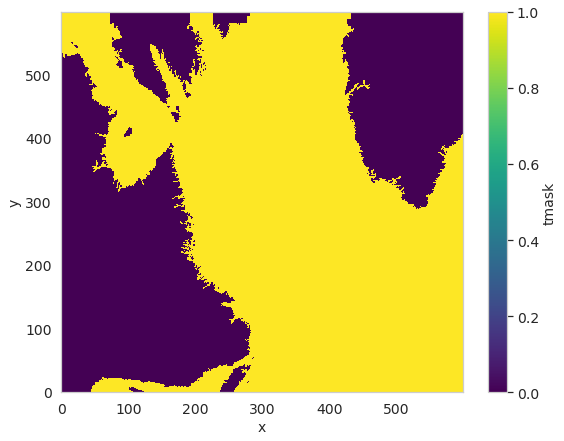

In [15]:
tmask.plot()

#### Adjust section coordinates for the reduced area

In [16]:
vertices_ji = vertices_ji - np.array([ymin,xmin])
vertices_ji = vertices_ji[0:6]
print(vertices_ji)

[[ 59 270]
 [ 69 350]
 [ 95 398]
 [272 467]
 [292 499]
 [294 552]]


### Select and mask the variables required for the calculation

sohefldo -- downward heat flux [W m$^{-2}$]  
sowaflup -- upward freshwater flux [kg m$^{-2}$]  
sosstsst -- surface potential temperature [deg C]  
sosaline -- surface salinity [PSU]  

In [17]:
surface = xr.Dataset()
surface = surface.assign({'sohefldo':gridT.sohefldo.where(tmask > 0.5)})
surface = surface.assign({'sowaflup':gridT.sowaflup.where(tmask > 0.5)})
surface = surface.assign({'sosstsst':gridT.sosstsst.where(tmask > 0.5)})
surface = surface.assign({'sosaline':gridT.sosaline.where(tmask > 0.5)})
surface

<xarray.Dataset>
Dimensions:        (y: 599, x: 600, time_counter: 12)
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(599, 600), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(599, 600), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 1990-01-16T12:00:00 ... 1990...
Dimensions without coordinates: y, x
Data variables:
    sohefldo       (time_counter, y, x) float32 dask.array<chunksize=(12, 599, 600), meta=np.ndarray>
    sowaflup       (time_counter, y, x) float32 dask.array<chunksize=(12, 599, 600), meta=np.ndarray>
    sosstsst       (time_counter, y, x) float32 dask.array<chunksize=(12, 599, 600), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(12, 599, 600), meta=np.ndarray>

### Add sigma0, expansion coeffs and heat capacity to surface dataset

Calculated using the seawater package as this is the equation of state used in VIKING20X  
Should modify these to use xr.apply_ufunc for efficiency

In [18]:
surface = surface.assign({'sosigma0':xr.DataArray(sw.dens(surface.sosaline,surface.sosstsst,0) - 1000.0,
                                                  dims=('time_counter','y','x'))})


In [19]:
surface = surface.assign({'alpha':xr.DataArray(sw.alpha(surface.sosaline,surface.sosstsst,0,True),
                                               dims=('time_counter','y','x'))})

In [20]:
surface = surface.assign({'beta':xr.DataArray(sw.beta(surface.sosaline,surface.sosstsst,0,True),
                                               dims=('time_counter','y','x'))})

In [21]:
surface = surface.assign({'cp':xr.DataArray(sw.cp(surface.sosaline,surface.sosstsst,0),
                                            dims=('time_counter','y','x'))})

### Mask the calculation area

This may not exactly match the brokenline calculation along OSNAP, but it will be very close as the same OSNAP array coordinates are used.

In [22]:
def apply_left_of_line(ds, lon_1, lon_2, lat_1, lat_2):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected while they are in a selected area.
    '''
    # particles are selected if they pass through given area.
    position =  ((lon_2 -lon_1) * (ds.nav_lat - lat_1) - 
                     (ds.nav_lon - lon_1) * (lat_2 - lat_1))
                        
    return position > 0.0, position < 0

In [23]:
# do north and south separately because of missing values

south = xr.Dataset()
north = xr.Dataset()
for i in range(len(lonlat.lon)-1):
    south['subsect'+str(i)],north['subsect'+str(i)] = apply_left_of_line(surface,lonlat.lon[i+1],lonlat.lon[i],lonlat.lat[i+1],lonlat.lat[i])

# check in osnap west, cutoff at 44W, tip of Greenland.
south_ow,north_ow = apply_left_of_line(surface,-44,-44,60,30)

north_a = north.subsect0 * north.subsect1 * north.subsect2 
north_b = north.subsect3 + north.subsect4 + north.subsect5
north_all = north_ow * (north_a  + north_b)


In [24]:
north_all = north_all.compute()

### mask hudson bay at x = 100

In [25]:
not_hudson = (surface.x > 100).compute()

### apply masks

In [26]:
surface_ls = surface.where(north_all & not_hudson)

In [27]:
surface_ls

<xarray.Dataset>
Dimensions:        (time_counter: 12, y: 599, x: 600)
Coordinates:
  * time_counter   (time_counter) datetime64[ns] 1990-01-16T12:00:00 ... 1990...
    nav_lat        (y, x) float32 49.36 49.37 49.37 49.37 ... 68.57 68.58 68.58
    nav_lon        (y, x) float32 -69.43 -69.38 -69.33 ... -43.5 -43.44 -43.37
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    dim_0          int64 1
Dimensions without coordinates: y, x
Data variables:
    sohefldo       (time_counter, y, x) float32 dask.array<chunksize=(12, 599, 600), meta=np.ndarray>
    sowaflup       (time_counter, y, x) float32 dask.array<chunksize=(12, 599, 600), meta=np.ndarray>
    sosstsst       (time_counter, y, x) float32 dask.array<chunksize=(12, 599, 600), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(12, 599, 600), meta=np.ndarray>
    sosigma0       (time_counter, y, x) float32 nan nan nan nan ... nan nan nan
    alpha          (time_counter, y, x) float32 nan nan nan nan ... nan nan nan
    beta           (time_counter, y, x) float32 nan nan nan nan ... nan nan nan
    cp             (time_counter, y, x) float32 nan nan nan nan ... nan nan nan

### Just an example plot to show the selected study area

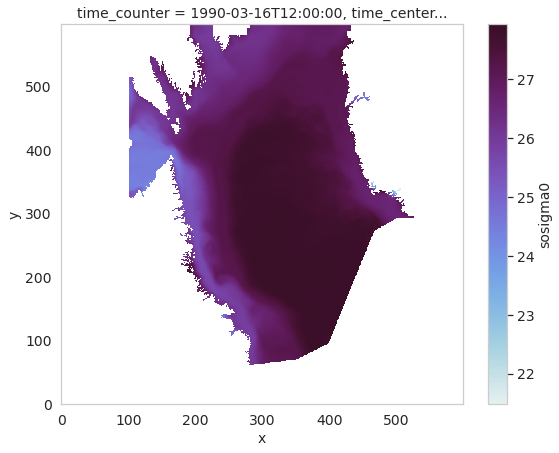

In [28]:
surface_ls.sosigma0.isel(time_counter=2).plot(cmap=co.cm.dense)

In [29]:
surface_area = mesh_mask.e1t*mesh_mask.e2t

## Calculate the volume transformations by sigma0 bin

### Equation

#### Heat

Vol_flux_in_sverdrups_at_sig0_to_denser_by_heat = sum_at_sig0(-1.0 * downward_heat_flux * surface_area * alpha/ 
                                (1e06* cp * deltarho))
                                
deltarho is the width of the density bin  
cp specific ht capacity  
alpha expansion coefficient  

#### Freshwater

Split upward freshwater into a volume flux up at local T and S and a salt flux down, which are then summed.  
vol_flux_sigma = sum_0_to_sig0{((water_flux * surface_area)/ 
                                    (1e06*rho_fw )))}  
salt_flux_sigma = sum_at_sig0(((water_flux * surface_area * sosaline * beta * (sosigma0+1000.0) )/ 
                                    (1e06 * deltarho * rho_fw ))))  
rho_fw = density of freshwater (assumed 1000 km m^-3), possibly should be at local temperature but errors will be small.  
beta = expansion coeff [PSU^-1]

#### Note

Supply bin bounds to xhistogram.xarray.histogram, and it returns bin centres.

vol_flux_sigma needs to be summed for density < rho  
heat_flux_sigma and salt_flux_sigma need to be between rho-deltarho/2 and rho+deltarho/2


In [30]:
def calculate_fluxes_by_heat_by_sigma0(heat_flux,surface_area,sosigma0,alpha,cp):
    """ Calculate surface heat fluxes binned on sigma layers

    Parameters
    ----------
    heat_flux: xarray.DataArray
        DataArray containing heat fluxes [Wm^{-2}]
    surface_area: xarray.DataArray
        DataArray containing gridbox surface areas [m^2]
    sosigma0: xarray.DataArray
        DataArray containing surface sigma0
        
    Returns
    -------
    heat_flux_sigma : xarray.Dataset
        Dataset of shape (t,sigma)
        "t" - time
        "sigma" - density bins centre
    surface_area_sigma : xarray.Dataset
        Dataset of shape (t,sigma)
        "t" - time
        "sigma" - density bins centre

    """
    
    
    deltarho = 0.01
    
    sigbins = np.arange(10,28.0001, deltarho)
    sigbins_c = np.arange(10 + (deltarho/2),28.0001+ (deltarho/2), deltarho)

    heat_flux_sigma = histogram(sosigma0, 
                                bins=[sigbins_c], 
                                dim=["x","y"], 
                                weights=-1.0* heat_flux * surface_area * alpha/ 
                                (1e06* cp * deltarho))
    heat_flux_sigma.attrs["long_name"]='volume flux'
    heat_flux_sigma.sosigma0_bin.attrs["long_name"]= r"$ \sigma _\theta $"
    heat_flux_sigma.time_counter.attrs["long_name"]= "Date"
    heat_flux_sigma.sosigma0_bin.attrs["units"]= "kg m$^{-3}$"
    heat_flux_sigma.attrs["units"]='Sv'
    surface_area_sigma = histogram(sosigma0, bins=[sigbins_c], dim=["x","y"], weights=surface_area)
    surface_area_sigma.attrs["long_name"]='Surface area'
    surface_area_sigma.sosigma0_bin.attrs["long_name"]= r"$ \sigma _\theta $"
    surface_area_sigma.time_counter.attrs["long_name"]= "Date"
    surface_area_sigma.sosigma0_bin.attrs["units"]= "kg m$^{-3}$"
    surface_area_sigma.attrs["units"]='m$^2$'
    
    return heat_flux_sigma,surface_area_sigma

In [31]:
def calculate_fluxes_by_freshwater_by_sigma0(water_flux,surface_area,sosigma0,sosaline,beta):
    """ Calculate surface heat fluxes binned on sigma layers

    Parameters
    ----------
    water_flux: xarray.DataArray
        DataArray containing heat fluxes [Wm^{-2}]
    surface_area: xarray.DataArray
        DataArray containing gridbox surface areas [m^2]
    sosigma0: xarray.DataArray
        DataArray containing surface sigma0
        
    Returns
    -------
    freshwater_volume_flux_sigma : xarray.DataArray
        Dataset of shape (t,sigma)
        "t" - time
        "sigma" - density bins
    salinity_area_sigma : xarray.DataArray
        Dataset of shape (t,sigma)
        "t" - time
        "sigma" - density bins
    surface_area_sigma : xarray.Dataset
        Dataset of shape (t,sigma)
        "t" - time
        "sigma" - density bins upper
        

    """
    
    
    deltarho = 0.01
    rho_fw = 1000.0  # density of fresh water
    
    sigbins = np.arange(10,28.0001, deltarho)
    sigbins_c = np.arange(10 + (deltarho/2),28.0001+(deltarho/2), deltarho)

    vol_flux_sigma = histogram(sosigma0, 
                                      bins=[sigbins], 
                                      dim=["x","y"], 
                                      weights=((water_flux * surface_area)/ 
                                    (1e06*rho_fw )))
    salt_flux_sigma = histogram(sosigma0, 
                                      bins=[sigbins_c], 
                                      dim=["x","y"], 
                                      weights=((water_flux * surface_area * sosaline * beta * (sosigma0+1000.0) )/ 
                                    (1e06 * deltarho*rho_fw )))

#  use upper bounds of bins for volume flux    
    vol_flux_sigma["sosigma0_bin"]=salt_flux_sigma.sosigma0_bin
    
    freshwater_flux_sigma = salt_flux_sigma + vol_flux_sigma.cumsum(dim='sosigma0_bin')
    freshwater_flux_sigma.attrs["long_name"]='volume flux'
    freshwater_flux_sigma.sosigma0_bin.attrs["long_name"]= r"$ \sigma _\theta $"
    freshwater_flux_sigma.time_counter.attrs["long_name"]= "Date"
    freshwater_flux_sigma.sosigma0_bin.attrs["units"]= "kg m$^{-3}$"
    freshwater_flux_sigma.attrs["units"]='Sv'
    surface_area_sigma = histogram(sosigma0, bins=[sigbins], dim=["x","y"], weights=surface_area)
    surface_area_sigma["sosigma0_bin"]=salt_flux_sigma.sosigma0_bin
    surface_area_sigma.attrs["long_name"]='Surface area'
    surface_area_sigma.sosigma0_bin.attrs["long_name"]= r"$ \sigma _\theta $"
    surface_area_sigma.time_counter.attrs["long_name"]= "Date"
    surface_area_sigma.sosigma0_bin.attrs["units"]= "kg m$^{-3}$"
    surface_area_sigma.attrs["units"]='m$^2$'
    
    return freshwater_flux_sigma, surface_area_sigma

In [32]:
heat_flux_sigma,surface_area_sigma_centre = calculate_fluxes_by_heat_by_sigma0(surface_ls.sohefldo,
                                                                surface_area,
                                                                surface_ls.sosigma0,
                                                                surface_ls.alpha,
                                                                surface_ls.cp)

In [33]:
freshwater_flux_sigma,surface_area_sigma_upper = calculate_fluxes_by_freshwater_by_sigma0(surface_ls.sowaflup,
                                                                surface_area,
                                                                surface_ls.sosigma0,
                                                                surface_ls.sosaline,
                                                                surface_ls.beta)

### Save the results

This is the calculation done.

In [35]:
!mkdir -p {str(path_data_output)}

In [36]:
filename_output = 'heat_flux_sigma_' + mean_period + '_' + yearstr + '.nc'
heat_flux_sigma.to_netcdf(path_data_output / filename_output)

In [37]:
filename_output = 'freshwater_flux_sigma_' + mean_period + '_' + yearstr + '.nc'
freshwater_flux_sigma.to_netcdf(path_data_output / filename_output)

In [38]:
filename_output = 'surface_area_sigma_centre_' + mean_period + '_' + yearstr + '.nc'
surface_area_sigma_centre.to_netcdf(path_data_output / filename_output)

In [39]:
filename_output = 'surface_area_sigma_upper_' + mean_period + '_' + yearstr + '.nc'
surface_area_sigma_upper.to_netcdf(path_data_output / filename_output)

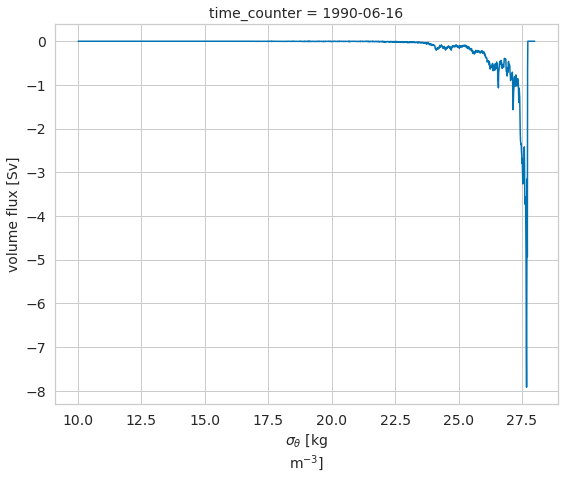

In [40]:
heat_flux_sigma.isel(time_counter = 5).plot()

In [41]:
conda list

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       1_gnu    conda-forge
alembic                   1.7.3              pyhd8ed1ab_0    conda-forge
ansiwrap                  0.8.4                      py_0    conda-forge
anyio                     3.3.2            py38h578d9bd_0    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               20.1.0           py38h497a2fe_2    conda-forge
asciitree                 0.3.3                      py_2    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
babel                     2.9.1              pyh44b312d_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports     

In [42]:
pip list

Package                       Version
----------------------------- ---------
alembic                       1.7.3
ansiwrap                      0.8.4
anyio                         3.3.2
appdirs                       1.4.4
argon2-cffi                   20.1.0
asciitree                     0.3.3
async-generator               1.10
attrs                         21.2.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
basemap                       1.2.1
black                         21.9b0
bleach                        4.1.0
blinker                       1.4
blosc                         1.10.2
bokeh                         2.3.3
Bottleneck                    1.3.2
brotlipy                      0.7.0
cached-property               1.5.2
cachetools                    4.2.2
Cartopy                       0.18.0
certifi                       2021.5.30
certipy                       0.1.3
cffi                          1.14.6
cftime         

/opt/conda/lib/python3.8/site-packages/distributed/client.py:4716: RuntimeWarning: coroutine 'wait_for' was never awaited
  c.close(timeout=3)
/opt/conda/lib/python3.8/site-packages/distributed/client.py:4716: RuntimeWarning: coroutine 'Client._close' was never awaited
  c.close(timeout=3)
/opt/conda/lib/python3.8/site-packages/distributed/client.py:4716: RuntimeWarning: coroutine 'wait_for' was never awaited
  c.close(timeout=3)
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
